In [27]:
import cv2
import numpy as np
import mediapipe as mp

img = cv2.imread('../aHieu.jpg')

In [28]:
class FaceDetMesh:
    def __init__(self):
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5
        )

In [29]:
class NewFaceDetector:
    def __init__(self, img: np.ndarray):
        self.face_mesh = FaceDetMesh().face_mesh
        self.img = img
        self.img_H, self.img_W = img.shape[:2]
        self._face_landmarks = None
        self._cropped_bbox = None
        self._expanded_cropped_bbox = None
        self._cropped_face = None
        self._lmk5 = None
        self.output_size = 256
        
    @property
    def face_landmarks(self):
        if self._face_landmarks is None:
            self._face_landmarks = self.face_mesh.process(self.img.copy())
            self._face_landmarks = self._face_landmarks.multi_face_landmarks
        return self._face_landmarks
    
    def check_face_landmarks(self):
        return bool(self.face_landmarks)

    @staticmethod
    def find_central_point(points: list):
        points = np.array(points)
        x1 = points[:, 0].min()
        x2 = points[:, 0].max()
        y1 = points[:, 1].min()
        y2 = points[:, 1].max()
        return (int((x1 + x2) / 2), int((y1 + y2) / 2))
    
    @staticmethod
    def expand_box(img: np.ndarray, box: list):
        """
        this func for expand area near the face if face found
        Args:
            img (np.ndarray): original image 
            box (list): coordinate of face_crop

        Returns:
            np.ndarray: new coordinate
        """
        h, w = img.shape[:2]
        box_w = box[2] - box[0]
        box_h = box[3] - box[1]
        new_x1 = max(int(np.floor(box[0] - 2*box_w/5)), 0)
        new_x2 = min(int(np.floor(box[2] + 2*box_w/5)), w)
        new_y1 = max(int(np.floor(box[1] - 2*box_h/5)), 0)
        new_y2 = min(int(np.floor(box[3] + 2*box_h/5)), h)
        return [new_x1, new_y1, new_x2, new_y2]  

    @property
    def cropped_bbox(self):
        if self._cropped_bbox is None:
            if self.check_face_landmarks():
                list_points_xy = []
                for point in self.face_landmarks[0].landmark:
                    list_points_xy.append([int(np.floor(point.x * self.img_W)), int(np.floor(point.y * self.img_H))])
                list_points_xy = np.array(list_points_xy)
                x_list = list_points_xy[:, 0]
                y_list = list_points_xy[:, 1]
                x1 = x_list.min()
                x2 = x_list.max()
                y1 = y_list.min()
                y2 = y_list.max()
                self._cropped_bbox = [x1, y1, x2, y2]
            else:
                self._cropped_bbox = 0
        return self._cropped_bbox
    
    @property
    def expanded_cropped_bbox(self):
        if self._expanded_cropped_bbox is None:
            if self.cropped_bbox != 0:
                self._expanded_cropped_bbox = self.expand_box(self.img, self.cropped_bbox)
            else:
                self._expanded_cropped_bbox = 0
        return self._expanded_cropped_bbox
    
    @property
    def cropped_face(self):
        """
        Returns:
            np.ndarray: new face_crop are if face found else ori image
        """
        if self._cropped_face is None:
            if self.expanded_cropped_bbox != 0:
                self._cropped_face = self.img[self.expanded_cropped_bbox[1]:self.expanded_cropped_bbox[3], 
                                              self.expanded_cropped_bbox[0]:self.expanded_cropped_bbox[2]]
                # self._cropped_face = self.img.copy()
            else:
                self._cropped_face = self.img.copy()
        return self._cropped_face

    @property
    def lmk5(self):
        if self._lmk5 is None:
            if self.face_landmarks is not None:
                left_eye = [int((self.face_landmarks[0].landmark[159].x + self.face_landmarks[0].landmark[145].x) / 2*self.img_W), 
                int((self.face_landmarks[0].landmark[159].y + self.face_landmarks[0].landmark[145].y) / 2*self.img_H)]

                right_eye = [int((self.face_landmarks[0].landmark[386].x + self.face_landmarks[0].landmark[374].x) / 2*self.img_W), 
                int((self.face_landmarks[0].landmark[386].y + self.face_landmarks[0].landmark[374].y) / 2*self.img_H)]

                nose = [int((self.face_landmarks[0].landmark[19].x) * self.img_W), int((self.face_landmarks[0].landmark[19].y) * self.img_H)]

                left_mouth = [int((self.face_landmarks[0].landmark[61].x) * self.img_W), int((self.face_landmarks[0].landmark[61].y) * self.img_H)]

                right_mouth = [int((self.face_landmarks[0].landmark[291].x) * self.img_W), int((self.face_landmarks[0].landmark[291].y) * self.img_H)]

                self._lmk5 = [left_eye, right_eye, nose, left_mouth, right_mouth]

                for id, point in enumerate(self._lmk5):
                    self._lmk5[id] = [point[0] - self.expanded_cropped_bbox[0], point[1] - self.expanded_cropped_bbox[1]]
                self._lmk5 = np.array(self._lmk5)
            else:
                self._lmk5 = 0
        return self._lmk5

[[ 89 136]
 [168 134]
 [129 175]
 [101 211]
 [158 212]]


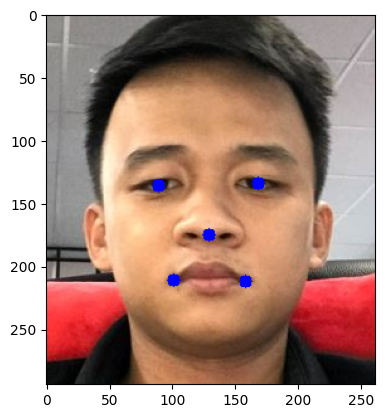

In [30]:
import matplotlib.pyplot as plt

face_det = NewFaceDetector(img)

print(face_det.lmk5)
test_lmk5 = face_det.cropped_face 
for point in face_det.lmk5:
    test_lmk5 = cv2.circle(test_lmk5.copy(), tuple(point), 1, (255,0,0), 8)
plt.imshow(test_lmk5[:,:,::-1])
plt.show()

43 115 213 301
35 115 221 301


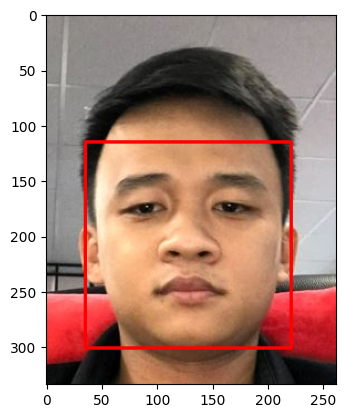

In [31]:
x1, y1, x2, y2 = face_det.cropped_bbox
print(x1, y1, x2, y2)
width = x2 - x1
height = y2 - y1
center_point = (int(x1 + width/2), int(y1 + height/2))
if width > height:
    std_size = width
    y1 = int(center_point[1] - std_size/2)
    y2 = y1 + std_size
elif width < height:
    std_size = height
    x1 = int(center_point[0] - std_size/2)
    x2 = x1 + std_size
print(x1, y1, x2, y2)
test = cv2.rectangle(face_det.img.copy(), (x1, y1), (x2, y2), [0,0,255], 2)
plt.imshow(test[:,:,::-1])
plt.show()

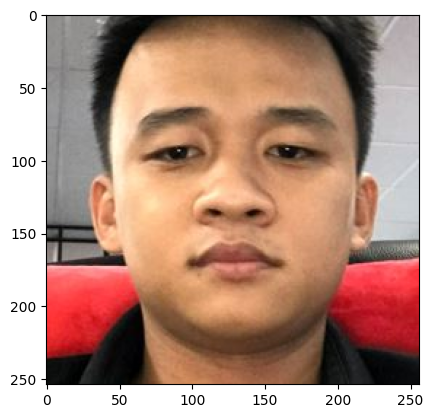

In [33]:
def expand_bbox(img, bbox):
    h, w = img.shape[:2]
    x1, y1, x2, y2 = bbox
    old_size = x2 - x1 
    coef_expand = 0.2
    border_width = min(int(coef_expand*old_size) - 1, x1, w - x2, y1, h - y1)
    new_x1 = x1 - border_width
    new_y1 = y1 - border_width
    new_x2 = x2 + border_width
    new_y2 = y2 + border_width
    return [new_x1, new_y1, new_x2, new_y2]

test_img = face_det.img.copy()
new_bbox = expand_bbox(test_img, [x1, y1, x2, y2])
final_img = test_img[new_bbox[1]:new_bbox[3], new_bbox[0]:new_bbox[2]]
plt.imshow(final_img[:,:,::-1])
plt.show()

    

FIX CODE FACE DETECTOR

In [72]:
import cv2
import numpy as np
import mediapipe as mp

img = cv2.imread('../male.jpg')

In [73]:
class FaceDetMesh:
    def __init__(self):
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5
        )

def resize_img(img: np.array, new_h=400, square=False):
    if square:
        new_img = cv2.resize(img, (new_h, new_h))
    else:
        old_h, old_w = img.shape[:2]
        ratio = new_h/old_h
        new_w = int(ratio*old_w)
        new_img =  cv2.resize(img, (new_w, new_h))
    return new_img

In [79]:
class NewFaceDetector:
    def __init__(self, img: np.ndarray):
        self.face_mesh = FaceDetMesh().face_mesh
        self.img = img
        self.img_H, self.img_W = img.shape[:2]
        self._face_landmarks = None
        self._cropped_bbox = None
        self._square_bbox = None
        self._expanded_cropped_bbox = None
        self._cropped_face = None
        self._lmk5 = None
        self.output_size = 256

    @property
    def face_landmarks(self):
        if self._face_landmarks is None:
            self._face_landmarks = self.face_mesh.process(self.img.copy())
            self._face_landmarks = self._face_landmarks.multi_face_landmarks
        return self._face_landmarks
    
    def check_face_landmarks(self):
        return bool(self.face_landmarks)

    @property
    def cropped_bbox(self):
        if self._cropped_bbox is None:
            if self.check_face_landmarks():
                list_points_xy = []
                for point in self.face_landmarks[0].landmark:
                    list_points_xy.append([int(np.floor(point.x * self.img_W)), int(np.floor(point.y * self.img_H))])
                list_points_xy = np.array(list_points_xy)
                x_list = list_points_xy[:, 0]
                y_list = list_points_xy[:, 1]
                x1 = x_list.min()
                x2 = x_list.max()
                y1 = y_list.min()
                y2 = y_list.max()
                self._cropped_bbox = [x1, y1, x2, y2]
            else:
                self._cropped_bbox = 0
        return self._cropped_bbox
    
    @property
    def square_bbox(self):
        if self._square_bbox is None:
            if self.cropped_bbox != 0:
                x1, y1, x2, y2 = self.cropped_bbox
                width = x2 - x1
                height = y2 - y1
                center_point = (int(np.floor(x1 + width/2)), int(np.floor(y1 + height/2)))
                if width > height:
                    std_size = width
                    y1 = int(np.floor(center_point[1] - std_size/2))
                    y2 = y1 + std_size
                elif width < height:
                    std_size = height
                    x1 = int(np.floor(center_point[0] - std_size/2))
                    x2 = x1 + std_size
                self._square_bbox = [x1, y1, x2, y2]
            else:
                self._square_bbox = 0
        return self._square_bbox

    @staticmethod
    def expand_bbox(img: np.ndarray, bbox: list, coef_expand=0.15):
        h, w = img.shape[:2]
        x1, y1, x2, y2 = bbox
        old_size = x2 - x1 
        border_width = min(int(np.floor(coef_expand*old_size)) - 1, x1, w - x2, y1, h - y2)
        new_x1 = x1 - border_width
        new_y1 = y1 - border_width
        new_x2 = x2 + border_width
        new_y2 = y2 + border_width
        return [new_x1, new_y1, new_x2, new_y2]

    @property
    def expanded_cropped_bbox(self):
        if self._expanded_cropped_bbox is None:
            if self.square_bbox != 0:
                self._expanded_cropped_bbox = self.expand_bbox(self.img, self.square_bbox)
            else:
                self._expanded_cropped_bbox = 0
        return self._expanded_cropped_bbox
    
    @property
    def cropped_face(self):
        """
        Returns:
            np.ndarray: new face_crop are if face found else ori image
        """
        if self._cropped_face is None:
            if self.expanded_cropped_bbox != 0:
                self._cropped_face = self.img[self.expanded_cropped_bbox[1]:self.expanded_cropped_bbox[3], 
                                              self.expanded_cropped_bbox[0]:self.expanded_cropped_bbox[2]]
                self._cropped_face = resize_img(img=self._cropped_face, new_h=self.output_size, square=True)
                # self._cropped_face = self.img.copy()
            else:
                self._cropped_face = self.img.copy()
        return self._cropped_face

    @property
    def lmk5(self):
        if self._lmk5 is None:
            if self.face_landmarks is not None:
                ratio = self.output_size / (self.expanded_cropped_bbox[2] - self.expanded_cropped_bbox[0])
                left_eye = [int((self.face_landmarks[0].landmark[159].x + self.face_landmarks[0].landmark[145].x) / 2*self.img_W), 
                int((self.face_landmarks[0].landmark[159].y + self.face_landmarks[0].landmark[145].y) / 2*self.img_H)]

                right_eye = [int((self.face_landmarks[0].landmark[386].x + self.face_landmarks[0].landmark[374].x) / 2*self.img_W), 
                int((self.face_landmarks[0].landmark[386].y + self.face_landmarks[0].landmark[374].y) / 2*self.img_H)]

                nose = [int((self.face_landmarks[0].landmark[19].x) * self.img_W), int((self.face_landmarks[0].landmark[19].y) * self.img_H)]

                left_mouth = [int((self.face_landmarks[0].landmark[61].x) * self.img_W), int((self.face_landmarks[0].landmark[61].y) * self.img_H)]

                right_mouth = [int((self.face_landmarks[0].landmark[291].x) * self.img_W), int((self.face_landmarks[0].landmark[291].y) * self.img_H)]

                self._lmk5 = [left_eye, right_eye, nose, left_mouth, right_mouth]

                for id, point in enumerate(self._lmk5):
                    self._lmk5[id] = [int(np.floor((point[0] - self.expanded_cropped_bbox[0])*ratio)), int(np.floor((point[1] - self.expanded_cropped_bbox[1])*ratio))]
                self._lmk5 = np.array(self._lmk5)
            else:
                self._lmk5 = 0
        return self._lmk5

[[ 90  89]
 [165  89]
 [127 144]
 [ 97 170]
 [158 170]]


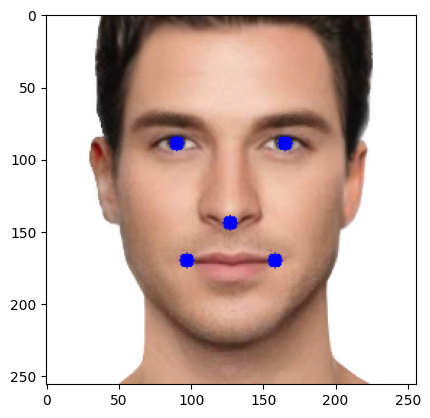

In [80]:
import matplotlib.pyplot as plt

face_det = NewFaceDetector(img)

print(face_det.lmk5)
test_lmk5 = face_det.cropped_face 
for point in face_det.lmk5:
    test_lmk5 = cv2.circle(test_lmk5.copy(), tuple(point), 1, (255,0,0), 8)
plt.imshow(test_lmk5[:,:,::-1])
plt.show()

[248, 272, 760, 784]


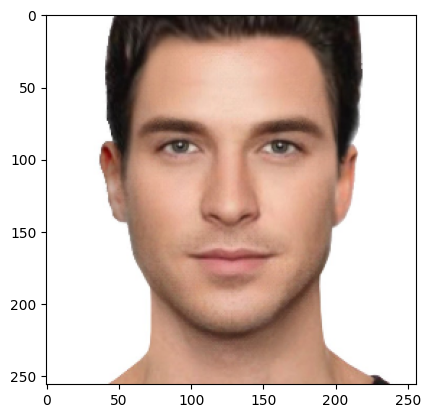

(256, 256, 3)


In [76]:
print(face_det.square_bbox)
cropped_face = face_det.cropped_face
plt.imshow(cropped_face[:,:,::-1])
plt.show()
print(cropped_face.shape)

In [51]:
int(np.floor(0.1))

0